In [2]:
import torch
import numpy as np
import random

### Frame_shift

In [3]:
def frame_shift(features, label=None, net_pooling=None):
    
    # Hmd: label exists always
    if label is not None:
        batch_size, _, _ = features.shape
        shifted_feature = []
        shifted_label = []
        for idx in range(batch_size):
            shift = int(random.gauss(0, 90))  # N(0, 90)인 정규분포에서 난수 추출 >> int
            shifted_feature.append(torch.roll(features[idx], shift, dims=-1))  # 시퀀스 방향으로 shift만큼 밀어버림
            # shift = -abs(shift) // net_pooling if shift < 0 else shift // net_pooling  # label을 생성할 때 4로 길이를 줄였기 때문에 net_pooling으로 나눠주는 거.
            shifted_label.append(torch.roll(label[idx], shift, dims=-1))
        return torch.stack(shifted_feature), torch.stack(shifted_label)  
    
    else:
        batch_size, _, _ = features.shape
        shifted_feature = []
        for idx in range(batch_size):
            shift = int(random.gauss(0, 90))
            shifted_feature.append(torch.roll(features[idx], shift, dims=-1))
        return torch.stack(shifted_feature)

In [24]:
feature = torch.randn(4,4)

print(feature)

shifted_feature = torch.roll(feature, 1, dims=-1)

print(shifted_feature)

tensor([[ 1.1879,  1.3670, -0.0242,  0.8435],
        [ 1.4010, -0.7276,  0.4552, -0.1346],
        [-1.7923,  1.0895, -0.2323,  0.4347],
        [-0.3259,  2.0789,  0.8266,  1.8056]])
tensor([[ 0.8435,  1.1879,  1.3670, -0.0242],
        [-0.1346,  1.4010, -0.7276,  0.4552],
        [ 0.4347, -1.7923,  1.0895, -0.2323],
        [ 1.8056, -0.3259,  2.0789,  0.8266]])


In [20]:
feature = torch.randn(110, 40, 298)
rolled_feature = torch.roll(feature, 2, dims= -1)
rolled_feature.shape

torch.Size([110, 40, 298])

In [6]:
a = torch.randn(110, 40, 298)

shifted_batch = frame_shift(a)

shifted_batch.shape

torch.Size([110, 40, 298])

### Mix-up

In [1]:
# In pytorch Trainer

def apply_mixup(self, features, embeddings, labels, start_indx, stop_indx):
    # made a dedicated method as we need to apply mixup only
    # within each dataset that has the same classes
    mixup_type = self.hparams["training"].get("mixup")
    batch_num = features.shape[0]
    current_mask = torch.zeros(batch_num).to(features).bool()
    current_mask[start_indx:stop_indx] = 1
    features[current_mask], labels[current_mask] = mixup(
        features[current_mask], labels[current_mask],
        mixup_label_type=mixup_type
    )

    if embeddings is not None:
        # apply mixup also on embeddings
        embeddings[current_mask], labels[current_mask] = mixup(
            embeddings[current_mask], labels[current_mask],
            mixup_label_type=mixup_type
        )

    return features, embeddings, labels


def mixup(data, target=None, alpha=0.2, beta=0.2, mixup_label_type="soft"):
    
    with torch.no_grad():
        batch_size = data.size(0)
        c = np.random.beta(alpha, beta)

        perm = torch.randperm(batch_size)

        mixed_data = c * data + (1 - c) * data[perm, :]
        if target is not None:
            if mixup_label_type == "soft":
                mixed_target = torch.clamp(
                    c * target + (1 - c) * target[perm, :], min=0, max=1
                )
            elif mixup_label_type == "hard":
                mixed_target = torch.clamp(target + target[perm, :], min=0, max=1)
            else:
                raise NotImplementedError(
                    f"mixup_label_type: {mixup_label_type} not implemented. choice in "
                    f"{'soft', 'hard'}"
                )
            return mixed_data, mixed_target
        else:
            return mixed_data
        
        
def mixup_strong(data, seq_label, murmur_laebl, alpha=0.2, beta=0.2, mixup_label_type="soft"):
    
    with torch.no_grad():
        batch_size = data.size(0)
        c = np.random.beta(alpha, beta)

        perm = torch.randperm(batch_size)

        mixed_data = c * data + (1 - c) * data[perm, :]
        if seq_label is not None:
            if mixup_label_type == "soft":
                mixed_seq_label = torch.clamp(
                    c * seq_label + (1 - c) * seq_label[perm, :], min=0, max=1
                )
                mixed_murmur_label = torch.clamp(
                    c * murmur_laebl + (1 - c) * murmur_laebl[perm, :], min=0, max=1
                )
                
            elif mixup_label_type == "hard":
                mixed_seq_label = torch.clamp(seq_label + seq_label[perm, :], min=0, max=1)
                mixed_murmur_label = torch.clamp(murmur_laebl + murmur_laebl[perm, :], min=0, max=1)
            else:
                raise NotImplementedError(
                    f"mixup_label_type: {mixup_label_type} not implemented. choice in "
                    f"{'soft', 'hard'}"
                )  
            return mixed_data, mixed_seq_label, mixed_murmur_label
        else:
            return mixed_data


In [2]:
import numpy as np

alpha, beta = 0.2, 0.2

c = np.random.beta(alpha, beta)
c

0.8828339168063218

In [3]:
import torch

batch_size= 28

perm = torch.randperm(batch_size)
perm

tensor([ 5,  3, 21, 24, 26, 27,  7, 15,  6, 25,  8, 10, 14, 22, 19, 12,  9,  1,
        23, 11, 13, 20, 16,  0,  2, 17, 18,  4])

In [4]:
feature = torch.randn(32, 40, 298)

mixed_feature = mixup(feature)
mixed_feature.shape

torch.Size([32, 40, 298])

### Time-mask

In [ ]:
def time_mask(features, labels=None, net_pooling=None, mask_ratios=(10, 20)):
    
    # label is not None, always!
    if labels is not None:
        _, _, n_frame = labels.shape  # (bs, 10, 128), n_frame=128
        t_width = torch.randint(low=int(n_frame / mask_ratios[1]), high=int(n_frame/mask_ratios[0]), size=(1,))   # [low, high)  torch.randint(low=6, high= 12, size=(1, ))
        t_low = torch.randint(low=0, high=n_frame - t_width[0], size=(1,))   # torch.randint(low= 0, high= 118, size=(1,))
        
        features[:, :, t_low * net_pooling : (t_low + t_width) * net_pooling] = 0
        labels[:, :, t_low : t_low + t_width] = 0
        return features, labels
    
    else:
        _, _, n_frame = features.shape
        t_width = torch.randint(low=int(n_frame/mask_ratios[1]), high=int(n_frame/mask_ratios[0]), size=(1,))   # [low, high)
        t_low = torch.randint(low=0, high=n_frame-t_width[0], size=(1,))
        features[:, :, t_low:(t_low + t_width)] = 0
        return features

### Feature-transformation

In [ ]:
def feature_transformation(features, n_transform, choice, filter_db_range, filter_bands,
                           filter_minimum_bandwidth, filter_type, freq_mask_ratio, noise_snrs):
    
    # True
    if n_transform == 2:
        feature_list = []
        for _ in range(n_transform):
            features_temp = features # mels
            if choice[0]:
                features_temp = filt_aug(features_temp, db_range=filter_db_range, n_band=filter_bands,
                                         min_bw=filter_minimum_bandwidth, filter_type=filter_type)
            if choice[1]:
                features_temp = freq_mask(features_temp, mask_ratio=freq_mask_ratio)
            if choice[2]:
                features_temp = add_noise(features_temp, snrs=noise_snrs)
            feature_list.append(features_temp)
        
        
        # always n_transform is 2 
        return feature_list
    
    
    elif n_transform == 1:
        
        if choice[0]:
            features = filt_aug(features, db_range=filter_db_range, n_band=filter_bands,
                                min_bw=filter_minimum_bandwidth, filter_type=filter_type)
        if choice[1]:
            features = freq_mask(features, mask_ratio=freq_mask_ratio)
        if choice[2]:
            features = add_noise(features, snrs=noise_snrs)
        return [features, features]
    else:
        return [features, features]

### Filter-augmentation

In [ ]:
def filt_aug(features, db_range=[-6, 6], n_band=[3, 6], min_bw=6, filter_type="linear"):
    # this is updated FilterAugment algorithm used for ICASSP 2022
    if not isinstance(filter_type, str):
        if torch.rand(1).item() < filter_type:
            filter_type = "step"
            n_band = [2, 5]
            min_bw = 4
        else:
            filter_type = "linear"
            n_band = [3, 6]
            min_bw = 6

    batch_size, n_freq_bin, _ = features.shape
    n_freq_band = torch.randint(low=n_band[0], high=n_band[1], size=(1,)).item()   # [low, high)
    
    if n_freq_band > 1:
        while n_freq_bin - n_freq_band * min_bw + 1 < 0:
            min_bw -= 1
        band_bndry_freqs = torch.sort(torch.randint(0, n_freq_bin - n_freq_band * min_bw + 1,
                                                    (n_freq_band - 1,)))[0] + \
                           torch.arange(1, n_freq_band) * min_bw
        band_bndry_freqs = torch.cat((torch.tensor([0]), band_bndry_freqs, torch.tensor([n_freq_bin])))

        if filter_type == "step":
            band_factors = torch.rand((batch_size, n_freq_band)).to(features) * (db_range[1] - db_range[0]) + db_range[0]
            band_factors = 10 ** (band_factors / 20)

            freq_filt = torch.ones((batch_size, n_freq_bin, 1)).to(features)
            for i in range(n_freq_band):
                freq_filt[:, band_bndry_freqs[i]:band_bndry_freqs[i + 1], :] = band_factors[:, i].unsqueeze(-1).unsqueeze(-1)

        elif filter_type == "linear":
            band_factors = torch.rand((batch_size, n_freq_band + 1)).to(features) * (db_range[1] - db_range[0]) + db_range[0]
            freq_filt = torch.ones((batch_size, n_freq_bin, 1)).to(features)
            for i in range(n_freq_band):
                for j in range(batch_size):
                    freq_filt[j, band_bndry_freqs[i]:band_bndry_freqs[i+1], :] = \
                        torch.linspace(band_factors[j, i], band_factors[j, i+1],
                                       band_bndry_freqs[i+1] - band_bndry_freqs[i]).unsqueeze(-1)
            freq_filt = 10 ** (freq_filt / 20)
        return features * freq_filt

    else:
        return features

### Freq-mask

In [ ]:

def freq_mask(features, mask_ratio=16):
    batch_size, n_freq_bin, _ = features.shape
    max_mask = int(n_freq_bin/mask_ratio)
    if max_mask == 1:
        f_widths = torch.ones(batch_size)
    else:
        f_widths = torch.randint(low=1, high=max_mask, size=(batch_size,))   # [low, high)

    for i in range(batch_size):
        f_width = f_widths[i]
        f_low = torch.randint(low=0, high=n_freq_bin-f_width, size=(1,))

        features[i, f_low:f_low+f_width, :] = 0
    return features

### Add-noise

In [ ]:
import torch

In [ ]:
a = torch.randn(4,6)

torch.std(a)

In [1]:
def add_noise(features, snrs=(15, 30), dims=(1, 2)):
    if isinstance(snrs, (list, tuple)):
        snr = (snrs[0] - snrs[1]) * torch.rand((features.shape[0],), device=features.device).reshape(-1, 1, 1) + snrs[1]
    else:
        snr = snrs

    snr = 10 ** (snr / 20)
    sigma = torch.std(features, dim=dims, keepdim=True) / snr
    return features + torch.randn(features.shape, device=features.device) * sigma

In [2]:
cd /Data1/hmd2/notebooks_th/GRU_loss_add/

/Data1/hmd2/notebooks_th/GRU_loss_add


In [ ]:
import pathlib
import librosa
import torch
from dataset import*
import matplotlib.pyplot as plt


from IPython.display import display, Audio

data_path = pathlib.Path("/Data2/murmur/train/2530_AV.wav")

recording, sr  = librosa.load(data_path, sr= 4000)

spectogram, sr = calculate_features(torch.tensor(recording), sr)
spectogram.shape

In [14]:
def plot_spec(spectogram):
    # Plot the spectrogram
    plt.imshow(spectogram, aspect='auto', origin='lower')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(label='Amplitude')
    plt.title('Before add noise spectogram')
    plt.show()

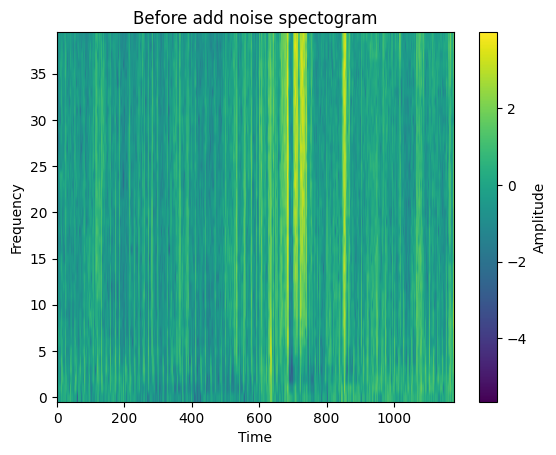

In [17]:
plot_spec(spectogram)

In [32]:
def add_gaussian_noise(features, w_noise, device=None):
    
    noise = torch.randn(features.shape)
    
    return features + noise * w_noise

In [37]:
spectogram.shape

torch.Size([40, 1178])

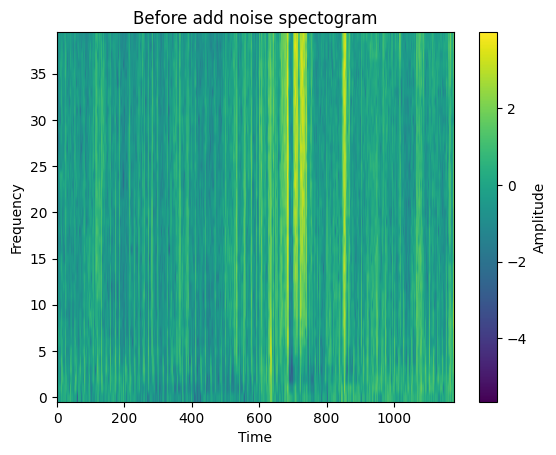

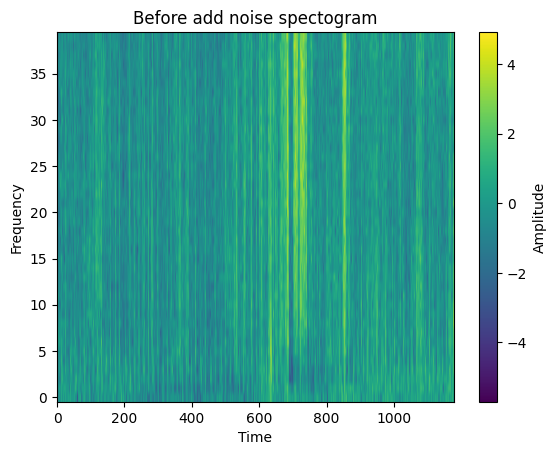

In [36]:
aug_spec = add_gaussian_noise(spectogram, 0.5)
plot_spec(spectogram)
plot_spec(aug_spec)

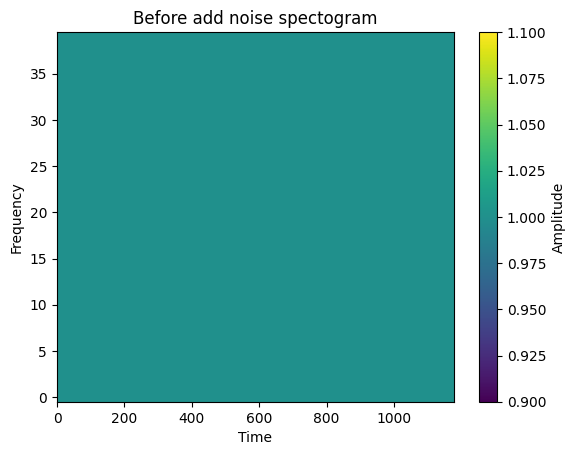

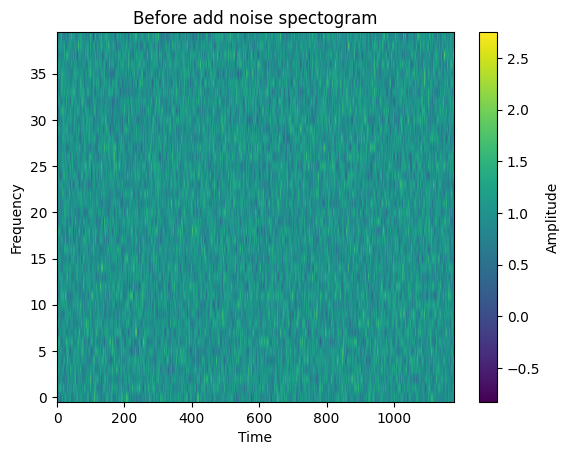

In [46]:
image = torch.ones(40, 1178).float()

aug_image = add_gaussian_noise(image, 0.4)

plot_spec(image)
plot_spec(aug_image)